# Background 
It is a Kaggle challenge using numerous biometric data to predict the occurance of Parkinson disease. The goal is to find the best performing model. 

In [1]:
# Connect to google drive to download dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Boruta

     |████████████████████████████████| 61kB 1.8MB/s 


In [2]:
# Load general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from boruta import BorutaPy

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
# Path to google drive
path = '/content/drive/My Drive/hw3/'

# Load both test and train dataset
train = pd.read_csv(path+'train_data.csv')
test = pd.read_csv(path+'test_data.csv')

train.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,z187,z188,z189,z190,z191,z192,z193,z194,z195,z196,z197,z198,z199,z200,z201,z202,z203,z204,z205,z206,z207,z208,z209,z210,z211,z212,z213,z214,z215,z216,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,-8.900000e-06,-0.806753,-0.805752,401,0.043217,0.001868,0.012497,-0.463844,5.481409,67,78,193,208,0.551122,0.548628,0.127182,0.124688,0.002506,0.007481,-0.746494,-2.239481,0.995012,2.172739,-0.689267,-0.906939,0.000347,0.000291,0.000559,1,1,...,0.884167,0.975227,0.049530,0.244356,0.849657,1.016763,0.063497,0.181115,0.800739,1.051462,0.062166,0.118377,0.740213,1.079210,0.274774,0.013800,0.005993,0.015053,1.022254,-0.204758,0.099795,0.062382,8.510045,-0.220163,0.019842,-0.123706,0.047685,0.069165,0.021831,-0.006764,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,8.830000e-07,-0.940358,-0.937867,401,0.080432,0.006469,-0.840971,5.311628,12.116713,45,65,194,207,0.384040,0.381546,0.376559,0.374065,0.002500,0.004988,-0.883335,-1.766671,0.997506,1.803625,-0.642837,-1.362523,0.005266,0.004333,-0.003138,1,1,...,-0.609756,-0.763147,0.021455,-0.053526,-0.593603,-0.814550,0.049806,-0.015306,-0.569004,-0.860919,0.065970,0.006677,-0.537949,-0.902051,0.075075,0.257914,0.042138,-0.009052,1.141471,-0.613013,0.305763,0.003132,-7.212686,-0.042147,-0.169557,-0.019917,-0.021723,0.000820,0.025202,0.034347,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,-9.220000e-05,0.240181,0.229315,401,0.274750,0.075487,-0.062232,-0.579688,14.667095,52,48,204,197,0.411471,0.408978,0.324190,0.321696,0.000000,0.000000,0.000000,0.000000,1.000000,2.121199,0.818939,-0.345764,-0.001580,-0.003453,-0.005586,1,1,...,1.669330,1.763907,0.025647,0.312827,1.620874,1.873061,-0.001876,0.203802,1.545267,1.969882,-0.030089,0.121656,1.447594,2.054081,0.131711,0.039174,0.015169,0.100816,1.366627,-0.926140,0.479792,-0.167468,17.736288,-0.326885,-0.153421,-0.172136,-0.361434,-0.182390,-0.116249,-0.101260,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,2.990000e-05,-0.978424,-0.977094,401,0.012307,0.000151,0.227388,-0.048079,3.178819,36,35,185,216,0.027431,0.024938,0.379052,0.376559,0.012626,0.024938,-4.876954,-9.753908,0.987531,2.185079,-0.936042,-1.012427,-0.000084,-0.000405,-0.000674,1,1,...,0.422560,0.536324,-0.010530,0.075108,0.419369,0.564408,-0.005335,0.055886,0.410019,0.588937,0.002191,0.042550,0.395474,0.609792,0.148457,0.007344,0.000267,-0.000647,0.454765,0.090908,0.204667,0.247985,4.269935,-0.030693,0.024398,0.015897,-0.065115,-0.014740,0.005236,0.018056,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,-2.060000e-05,-0.915454,-0.907291,401,0.032879,0.001081,0.746032,0.262103,4.029558,94,106,176,225,0.082294,0.079800,0.503741,0.501247,0.000000,0.000000,0.000000,0.000000,1.000000,2.063019,-0.774391,-0.971482,0.000072,0.000002,0.000007,1,1,...,0.578775,0.679124,-0.012262,0.036539,0.559355,0.721034,-0.010090,-0.008155,0.532373,0.758188,-0.025275,-0.036033,0.499854,0.790454,0.038829,0.011851,0.002387,0.021547,0.939191,-0.233462,0.082224,-0.073768,6.658360,-0.019151,-0.051658,0.074298,0.009625,-0.015878,-0.010804,-0.016153,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


# Exploratory Data Analysis

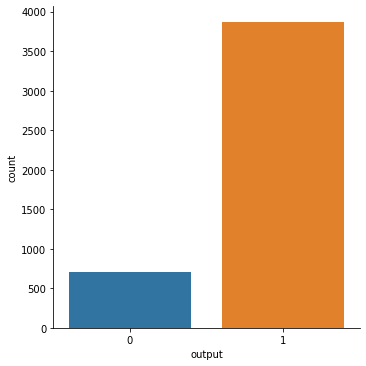

Percentage of 0 label is 15.51%


In [ ]:
# Plot the distribution of label
sns.catplot(x='output', kind='count', data=train)

plt.show()

print(f'Percentage of 0 label is {round(sum(train.output==0)*100/len(train),2)}%')

The dataset is unbalanced with around 15% of one class and 85% the other class.

### Visualizing data with PCA

In [ ]:
# Combine train and test data, one-hot-encoded categorical data
pca_data = pd.concat([train.drop(columns=['output','subject']), test.drop(columns=['subject'])])
pca_data = pd.get_dummies(pca_data, columns=['phase','state'])

# Scale data
pca_data = StandardScaler().fit_transform(pca_data)

# Run PCA 
model = PCA(n_components=2)

pca_data = model.fit_transform(pca_data)

# Create dataframe of PC1 & PC2
pca_result = pd.DataFrame(pca_data, columns=['pc1', 'pc2'])

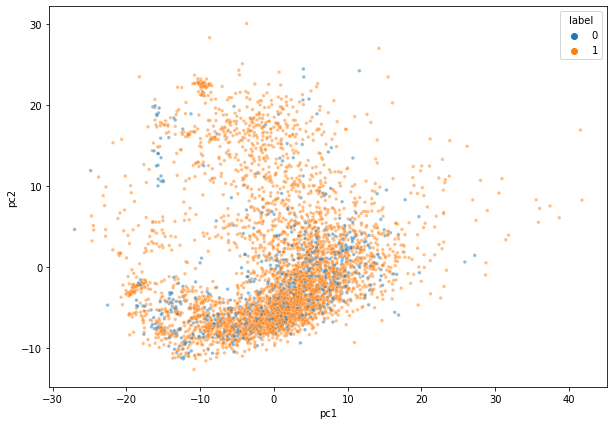

In [ ]:
# Visualize training data with output label
plot_data = pca_result.loc[train.index]
plot_data['label'] = list(train.output)

plt.figure(figsize=(10,7))
sns.scatterplot(data=plot_data, x='pc1', y='pc2', hue='label', s=12, alpha=0.5)

plt.show()

There is no clear separation of class labels with some small clusters. Classification would not be simple if just using numerical features alone.

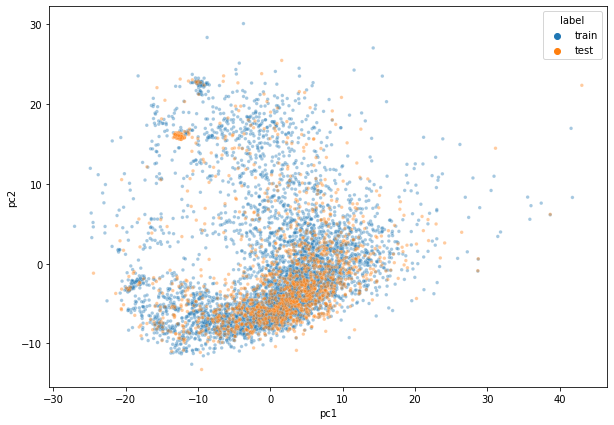

In [ ]:
# Visualize difference between train and test data
plot_data = pca_result.copy()
plot_data['label'] = ['train']*len(train) + ['test']*len(test)

plt.figure(figsize=(10,7))
sns.scatterplot(data=plot_data, x='pc1', y='pc2', hue='label', s=12, alpha=0.4)

plt.show()

A closer look at the train and test data shows that they may not be exactly the same. There are small pocket of test data that clearly separated from the train data (e.g. top left corner). The main different between the 2 dataset is the presence of 2 extra subjects in test data. We decide to test this hypothesis.

In [ ]:
print(f'Subjects in train data: {train.subject.unique()}')
print(f'Subjects in test data: {test.subject.unique()}')
print(f'Extra subjects in test data: {set(test.subject.unique())-set(train.subject.unique())}')

Subjects in train data: ['K' 'A' 'D' 'G' 'C' 'I' 'B' 'M' 'H' 'L' 'F']
Subjects in test data: ['E' 'H' 'C' 'A' 'K' 'I' 'J' 'D' 'L' 'B' 'F' 'G' 'M']
Extra subjects in test data: {'E', 'J'}


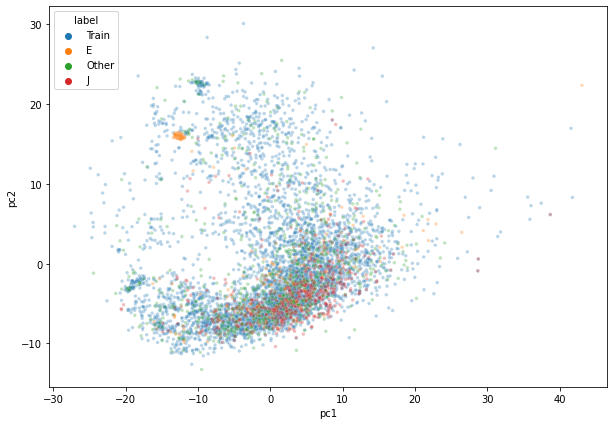

In [ ]:
# Visualize difference between different subject categories
plot_data = pca_result.copy()
plot_data['label'] = ['Train']*len(train) + list(test.subject)

# Replace subject label to 'others' if it is not 'J' or 'E'
plot_data.label = plot_data.label.replace(train.subject.unique(), 'Other')

plt.figure(figsize=(10,7))
sns.scatterplot(data=plot_data, x='pc1', y='pc2', hue='label', s=12, alpha=0.3)

plt.show()

Indeed, subject E seems to be well separated from the rest. Subject J also clusters together. It may be useful create 2 models: one general model with low variance for subject J and E; another low bias model for the rest of the group.

## Categorical features
There are three categorical features in this dataset (i.e. subject, phase, state)

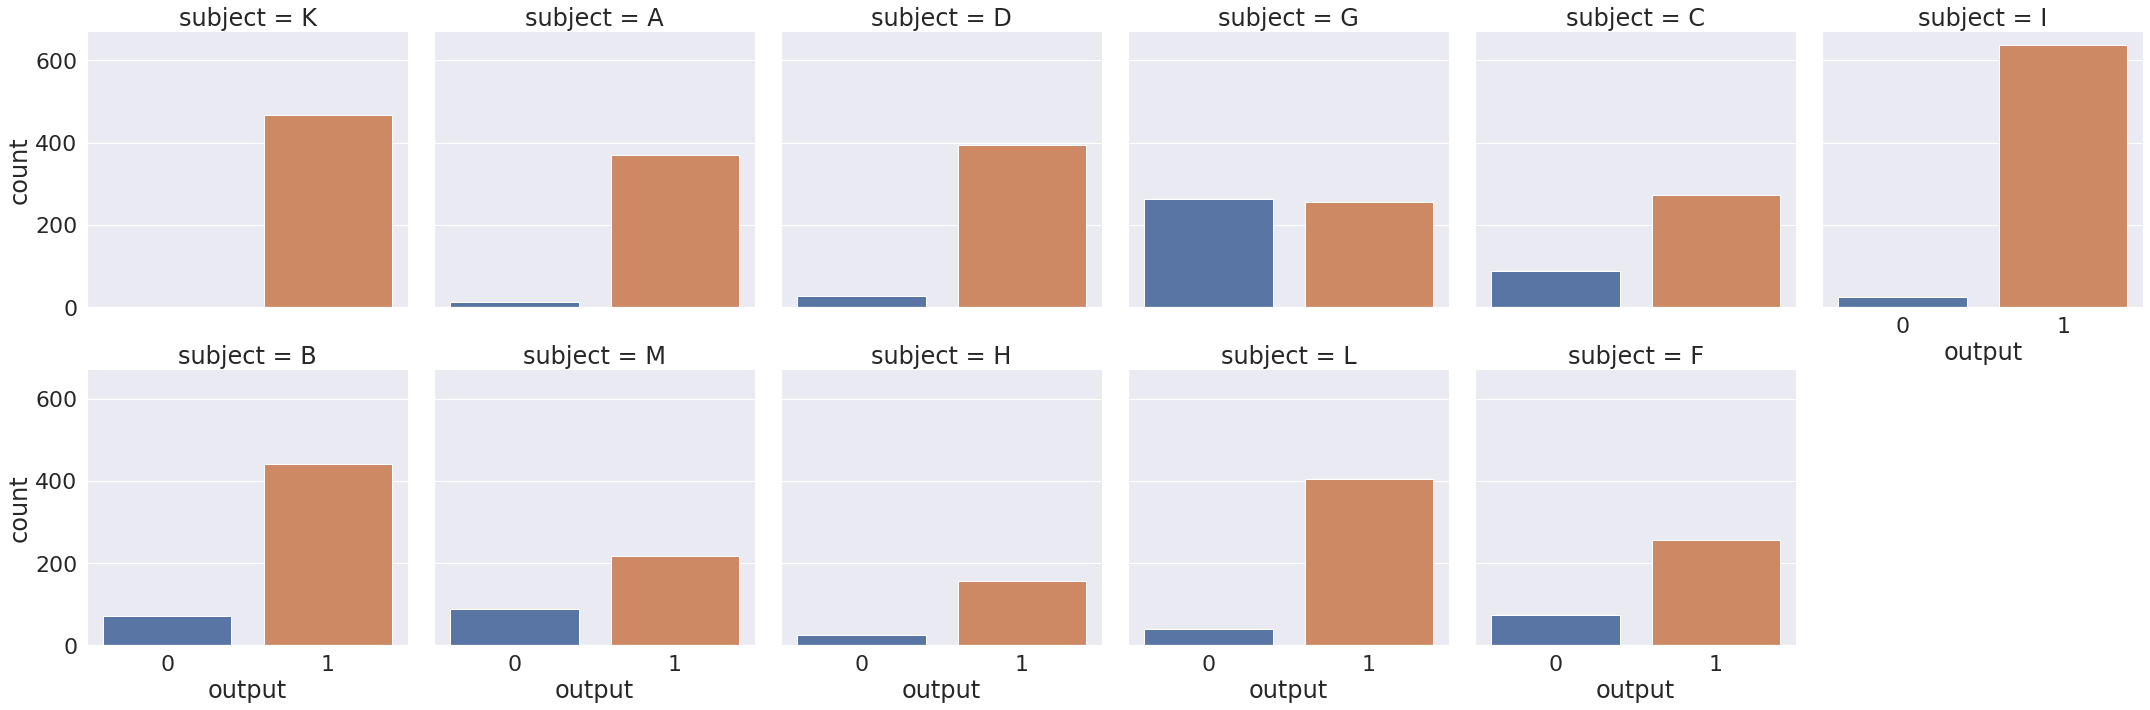

In [ ]:
# Plot categorical feature 'subject'
sns.set(font_scale=2)
sns.catplot(x='output', col='subject', kind='count', col_wrap=6, data=train)

plt.show()

The plot shows that there is obvious difference between different subject. Subject C has nearly equal amount of class 0 and 1, while class K and A have close to zero class 0.

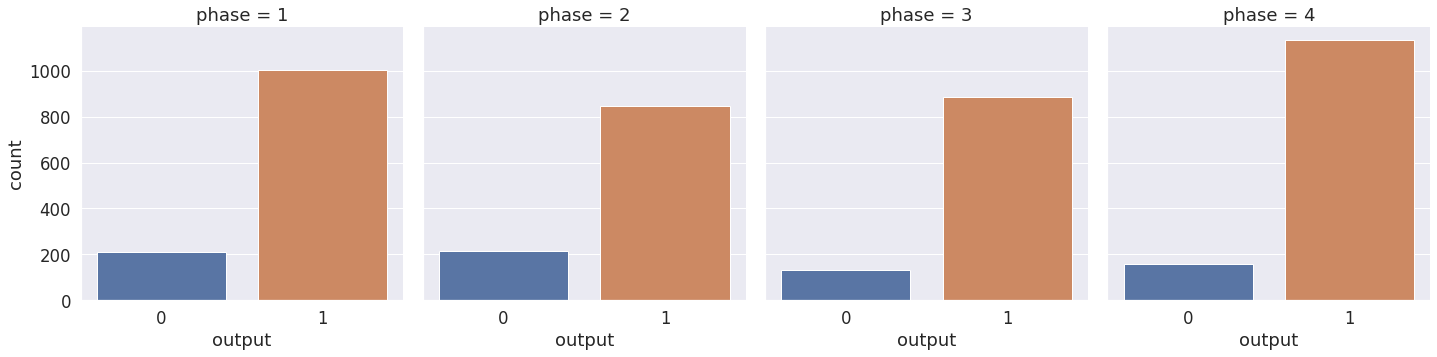

In [ ]:
# Plot categorical feature 'Phase'
sns.set(font_scale=1.5)
sns.catplot(x='output', col='phase', kind='count', col_wrap=4, data=train)

plt.show()

Categorical feature 'phase' also show some differece. Phase 1 and 2 have higher number of class 0, while phase 3 and 4 tend to have lower number of class 0.

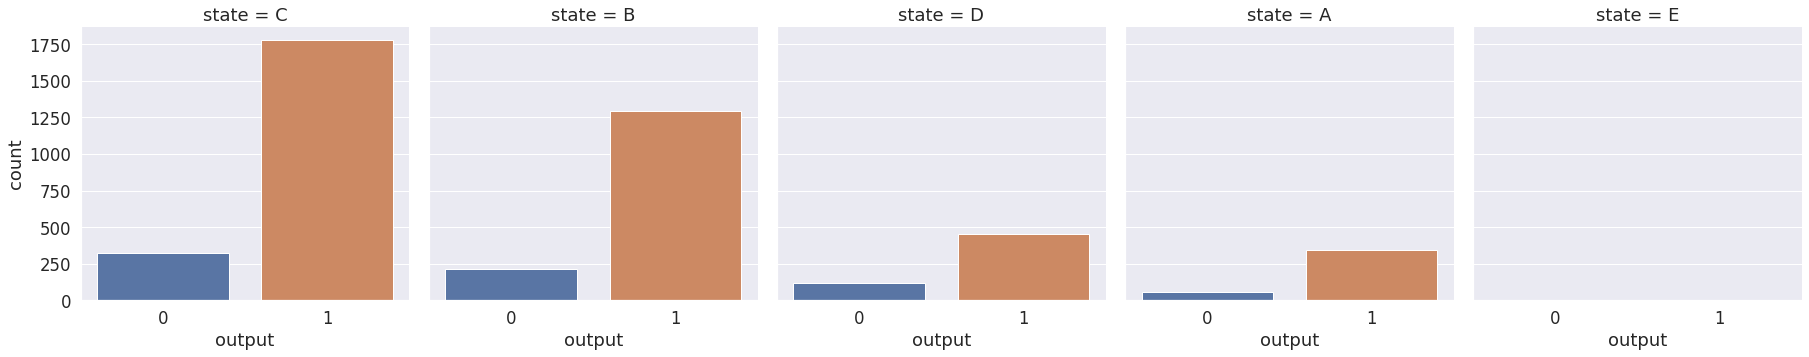

In [ ]:
# Plot categorical feature 'State'
sns.set(font_scale=1.5)
sns.catplot(x='output', col='state', kind='count', col_wrap=6, data=train)

plt.show()

There is little difference between different state. This categorical feature may not be an infirmative feature.

In [ ]:
# Chi-square test on each categorical features
categories = ['subject', 'phase', 'state']

for c in categories:
    table = pd.crosstab(train[c], train.output)

    stat, p, dof, expected = chi2_contingency(table)
    
    print(f'p-values of {c}: {round(p, 6)}')

p-values of subject: 0.0
p-values of phase: 0.0
p-values of state: 0.002505


As we speculated from the figures, chi-square test shows that both feature 'subject' and 'phase' are highly significant. State is also significant with a much higher p-value.

## Categorical features (test dataset)
Interestingly, the distribution of categorical feature in test dataset seems different from the train dataset.

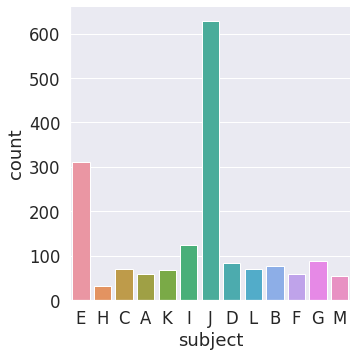

In [ ]:
# Plot distribution of feature 'subject' in test data 
sns.set(font_scale=1.5)
sns.catplot(x='subject', kind='count', data=test)

plt.show()

The number of categories is different from the train dataset. There are 2 extra subjects 'E' and 'J' in the test dataset. Given that subject is a important feature, prediction on these data points may require a different model.

## Summary I
1.   Dataset is unbalanced, weight should be adjusted in the models or using up/down sampling method.
2.   Test and train dataset is not similar at all. 
3. A small cluster of subject E seems very distinct from the rest of data point. I could assume that all of them are '0' or '1'.

## Strategy:
1. Find the best classifer model for all subject except 'J', 'E'
2. FInd a general model to avoid overfitting for subject 'J' and 'E'
3. Classify the distinct cluster of subject E into 1 single class  







# Data preparation

### Remove constant and duplicated features

There are over 600 numeric features in this dataset. Some features have constant values, or duplicated values as other features. These features will be removed to simplify the analysis. 

In [4]:
# List to store number of removed columns
removed = list()

# Remove categorical features
num_train = train.drop(['subject', 'phase', 'state', 'output'], axis=1)
num_col = num_train.shape[1]
removed.append(['Original', num_col])

# Remove uninformative columns with constant value
num_train = num_train.loc[:, num_train.nunique(axis=0)>1]
removed.append(['Constant', (num_col-num_train.shape[1])])
num_col = num_train.shape[1]

# Remove duplicated features
num_train = num_train.T.drop_duplicates(keep='first').T
removed.append(['Duplicated', (num_col-num_train.shape[1])])
num_col = num_train.shape[1]

#pd.DataFrame(removed, columns=['Numeric Features','Number'], index=['']*len(removed))

### Remove low variance and highly correlated features

In [5]:
# Remove low variance features
selector = VarianceThreshold(0.01)
selector.fit(num_train)

num_train = num_train.iloc[:,selector.get_support(indices=True)]
removed.append(['Duplicated', (num_col-num_train.shape[1])])
num_col = num_train.shape[1]

In [6]:
# Calculate correlation matrix
cor = num_train.corr().abs()

# Create a list of correlated features
correlated_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if cor.iloc[i, j] > 0.9:
            colname = cor.columns[i]
            correlated_features.add(colname)

# Remove highly correlated features
num_train.drop(labels=correlated_features, axis=1, inplace=True)
removed.append(['Highly correlated', (num_col-num_train.shape[1])])

pd.DataFrame(removed, columns=['Numeric Features','Number'], index=['']*len(removed))

,Numeric Features,Number
,Original,666
,Constant,108
,Duplicated,3
,Duplicated,163
,Highly correlated,217


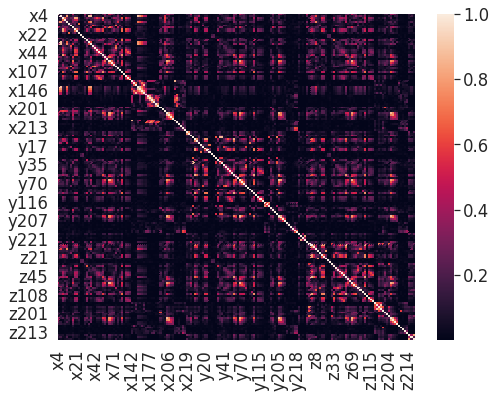

In [ ]:
# Check remaining features
cor = num_train.corr().abs()

plt.figure(figsize=(8,6))
sns.heatmap(cor)

plt.show()

A general overview of all the numerical features and their correlation.

### Create train and test dataset

In [24]:
# Combine one-hot-encoded catergorical data
SUBJECT = False   

# Include feature 'subject' if SUBJECT is true
if SUBJECT:
  X = train[list(num_train.columns) + ['subject','phase', 'state']]
  X = pd.get_dummies(X, columns=['subject','phase','state']) 

else:
  X = train[list(num_train.columns) + ['phase', 'state']]
  X = pd.get_dummies(X, columns=['phase','state']) 

Y = train.output

In [25]:
# Create train and test data
SEED = 123
#SCALER = RobustScaler() # scaling using quantile, but bad for this dataset (AUC 0.58)
SCALER = StandardScaler()

# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=SEED)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(SCALER.fit_transform(X), 
                                                                  Y, test_size=0.33, random_state=SEED)

print(f'Train dataset:{X_train.shape}  Test dataset:{X_test.shape}')

Train dataset:(3071, 184)  Test dataset:(1513, 184)


# Baseline Classifier
Different classifiers will be tested to get a baseline performance. Promising classifiers will be further optimized.

In [ ]:
# Utility function to calculate auc score
def get_auc_score(model, train_x, train_y, test_x, test_y):
  cv = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
  model.fit(train_x, train_y)
  pred_y = model.predict_proba(test_x)
  auc = roc_auc_score(test_y, pred_y[:,1])
  return cv, auc

In [14]:
# Utility function to show confusion matrix
target = [0,1]

def show_confusion_matrix(cm):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target))
    plt.xticks(tick_marks, target, rotation=60)
    plt.yticks(tick_marks, target)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Logistic regression

Regularization:l2  Test AUC:0.7924295173731994
Regularization:none  Test AUC:0.7893064372994744


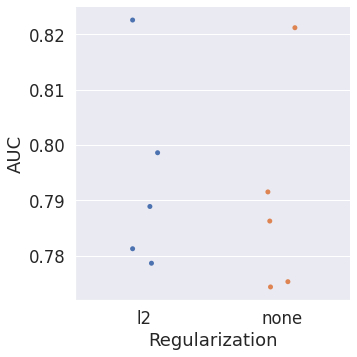

In [ ]:
values = ['l2','none']

# List to store CV results
result = list()

# Run CV on different parameter values
for value in values:
  model = LogisticRegression(penalty=value, random_state=0, class_weight='balanced', 
                             solver='lbfgs', max_iter=5000)
  cv, test_auc = get_auc_score(model, scaled_X_train, y_train, scaled_X_test, y_test)
  result.append(cv)
  print(f'Regularization:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['Regularization', 'AUC']

# Plot CV result
sns.catplot(x='Regularization', y='AUC', data=tmp)

plt.show()

Logistic regression with L2 regularization performs slightly better. But the general performance is not very good.

## K- nearest neighbours (KNN)

n_neighbors:5  Test AUC:0.75931804218718
n_neighbors:10  Test AUC:0.7817291282681412
n_neighbors:20  Test AUC:0.7846115775820874
n_neighbors:40  Test AUC:0.7851986483719025
n_neighbors:80  Test AUC:0.7764659703734044


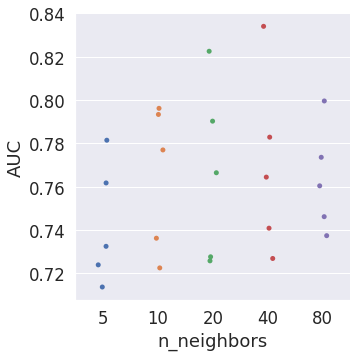

In [ ]:
# Number of K neighbor
values = [5,10,20,40,80]

# List to store CV results
result = list()

# Run CV on different parameter values
for value in values:
  model = KNeighborsClassifier(n_neighbors=value, weights='distance')
  cv, test_auc = get_auc_score(model, scaled_X_train, y_train, scaled_X_test, y_test)
  result.append(cv)
  print(f'n_neighbors:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['n_neighbors', 'AUC']

# Plot CV result
sns.catplot(x='n_neighbors', y='AUC', data=tmp)

plt.show()

The best n_neighbors is around ~40. However, the performance is not so great.

## Support vector classifier (SVC)
### Kernel choice

Kernel:linear  Test AUC:0.7802409720800055
Kernel:poly  Test AUC:0.804995221516827
Kernel:rbf  Test AUC:0.8268243566113727
Kernel:sigmoid  Test AUC:0.7560857396409311


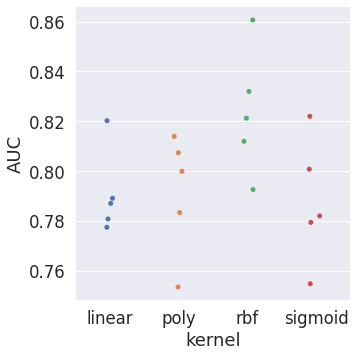

In [ ]:
# Kernel parameter for testing
values = ['linear', 'poly', 'rbf', 'sigmoid']
result = list()

# Run CV on different parameter values
for value in values:
  model = SVC(kernel=value, gamma='auto', class_weight='balanced', probability=True)
  cv, test_auc = get_auc_score(model, scaled_X_train, y_train, scaled_X_test, y_test)
  result.append(cv)
  print(f'Kernel:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['kernel', 'AUC']

# Plot CV result
sns.catplot(x='kernel', y='AUC', data=tmp)

plt.show()

### Optimize C value and gamma

In [ ]:
# Parameters for testing
C = [0.1, 1, 10, 100]  
gamma = ['auto', 'scale'] 

param_grid1 = {'C':C, 'gamma':gamma}
param_grid1

{'C': [0.1, 1, 10, 100], 'gamma': ['auto', 'scale']}

In [ ]:
# Use grid search to optimize parameter
model = SVC(kernel='rbf', class_weight='balanced', probability=True)
grid_search = GridSearchCV(model, param_grid=param_grid1, scoring='roc_auc', verbose=0, n_jobs=-1 , cv=5)
grid_search.fit(scaled_X_train, y_train) #Default 3 folds

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8240287876330594
{'C': 1, 'gamma': 'scale'}


In [ ]:
# Calculate AUC using optimized model
model = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', probability=True)
cv, test_auc = get_auc_score(model, scaled_X_train, y_train, scaled_X_test, y_test)

print(f'CV scores: {cv}')
print(f'Test AUC:{test_auc}')


CV scores: [0.79379453 0.83206046 0.82185088 0.86094353 0.81149453]
Test AUC:0.8264966891938016


The performance of SVC is similar to Logistic regression and KNN. 

## Random Forest


### Optimizing number of trees

n_estimators:100  Test AUC:0.835763533346986
n_estimators:200  Test AUC:0.8415369649805448
n_estimators:400  Test AUC:0.8482473206362209
n_estimators:700  Test AUC:0.8503532664345689
n_estimators:1000  Test AUC:0.8507662639087993


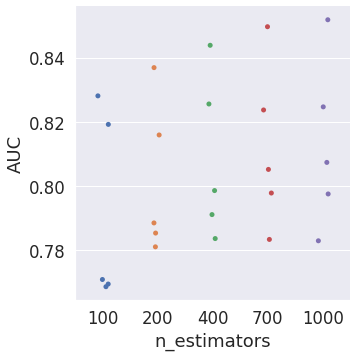

In [ ]:
# Parameter values for testing
values = [100,200,400,700,1000]

# List to store CV results
result = list()

# Run CV on different parameter values
for value in values:
  model = RandomForestClassifier(n_estimators=value, random_state=SEED, class_weight='balanced')
  cv, test_auc = get_auc_score(model, X_train, y_train, X_test, y_test)
  result.append(cv)
  print(f'n_estimators:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['n_estimators', 'AUC']

# Plot CV result
sns.catplot(x='n_estimators', y='AUC', data=tmp)

plt.show()

### Optimize max_depth, quality split

In [ ]:
# Parameters for testing
max_depth = [10, 20, 40, 80]  
criterion = ['gini', 'entropy'] 

param_grid1 = {'max_depth':max_depth, 'criterion':criterion}
param_grid1

{'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 40, 80]}

In [ ]:
# Use grid search to optimize parameter
model = RandomForestClassifier(n_estimators=1000, random_state=SEED, class_weight='balanced')
grid_search = GridSearchCV(model, param_grid=param_grid1, scoring='roc_auc', verbose=0, n_jobs=-1 , cv=5)
grid_search.fit(X_train, y_train) #Default 3 folds

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8220702126276949
{'criterion': 'entropy', 'max_depth': 40}


In [ ]:
# Calculate AUC using optimized model
model = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')
cv, test_auc = get_auc_score(model, X_train, y_train, X_test, y_test)

print(f'CV scores: {cv}')
print(f'Test AUC:{test_auc}')

CV scores: [0.78504757 0.83379529 0.81634729 0.85457891 0.8197796 ]
Test AUC:0.8503959314628986


Performance of random forest is much better. I will test it on the Kaggle submission.

## XGBoost

### Optimizing number of trees

n_estimators:100  Test AUC:0.8416717864700661
n_estimators:200  Test AUC:0.8407451020547477
n_estimators:400  Test AUC:0.8390572735340297
n_estimators:700  Test AUC:0.8376749266161514
n_estimators:1000  Test AUC:0.8347822376954059


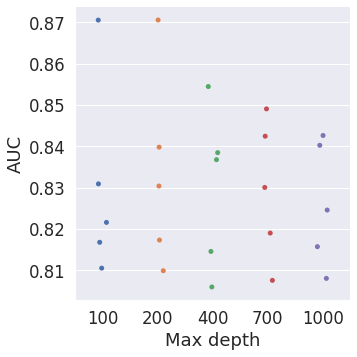

In [ ]:
# Parameter values for testing
values = [100,200,400,700,1000]

# List to store CV results
result = list()

# Run CV on different parameter values
for value in values:
  model = XGBClassifier(seed=SEED, n_estimators=value, colsample_bylevel=0.8,
                        colsample_bytree=0.7, reg_lambda=0.1,
                        scale_pos_weight = 0.18357862) #class ratio: 711/3873

  cv, test_auc = get_auc_score(model, X_train, y_train, X_test, y_test)
  result.append(cv)
  print(f'n_estimators:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['Max depth', 'AUC']

# Plot CV result
sns.catplot(x='Max depth', y='AUC', data=tmp)

plt.show()

### Optimizing learning rate, max_depth

In [ ]:
max_depth = [10, 20, 40, 80]  
learning_rate = [0.5, 0.01, 0.02]  

param_grid1 = {'learning_rate':learning_rate, 'max_depth':max_depth}
param_grid1

{'learning_rate': [0.5, 0.01, 0.02], 'max_depth': [10, 20, 40, 80]}

In [ ]:
model = XGBClassifier(seed=SEED, n_estimators=100, colsample_bylevel=0.8,
                        colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)
grid_search = GridSearchCV(model, param_grid=param_grid1, scoring='roc_auc', verbose=0, n_jobs=-1 , cv=5)
grid_search.fit(X_train, y_train) 

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8466937079895306
{'learning_rate': 0.02, 'max_depth': 20}


In [ ]:
# Calculate AUC using optimized model
model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)
cv, test_auc = get_auc_score(model, X_train, y_train, X_test, y_test)

print(f'CV scores: {cv}')
print(f'Test AUC:{test_auc}')

CV scores: [0.81359947 0.86880069 0.83763647 0.85581904 0.85761286]
Test AUC:0.8747273762240089


## Comparison of Random Forest and XGBoost

accuracy: 0.85195
Accuracy score: 0.85195" 
 

Confusion_matrix: 
 [[   4  224]
 [   0 1285]]


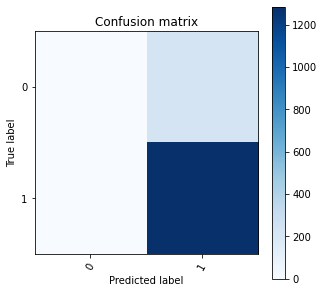

In [26]:
# Calculate AUC using optimized model
model = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("accuracy: %0.5f" % score)

#SVM_predprobability = clf.predict_proba(X_test)
print ('Accuracy score: %0.5f" \n' % score, '\n')

# Print out confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print ('Confusion_matrix: \n', c_matrix)
show_confusion_matrix(c_matrix)

accuracy: 0.86186
Accuracy score: 0.86186" 
 

Confusion_matrix: 
 [[  49  179]
 [  30 1255]]


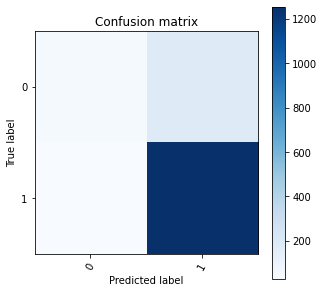

In [27]:
# Calculate AUC using optimized model
model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("accuracy: %0.5f" % score)

#SVM_predprobability = clf.predict_proba(X_test)
print ('Accuracy score: %0.5f" \n' % score, '\n')

# Print out confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print ('Confusion_matrix: \n', c_matrix)
show_confusion_matrix(c_matrix)

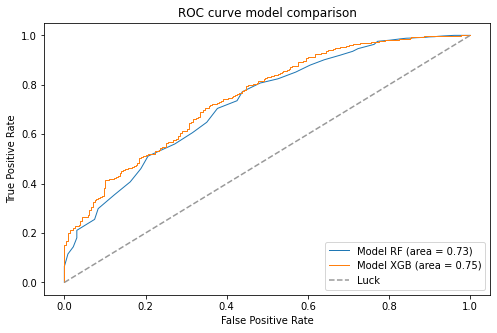

In [28]:
# Plot Roc for comparison
plt.figure(figsize=(8,5))

# Random Forest model
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')
probas_ = model.fit(X_train, y_train).predict_proba(X_test) 
    
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Model %s (area = %0.2f)' % ('RF', roc_auc))

# XGBoost model
model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)
probas_ = model.fit(X_train, y_train).predict_proba(X_test) 
    
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Model %s (area = %0.2f)' % ('XGB', roc_auc))

# plot neutral
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve model comparison')
plt.legend(loc="lower right")
plt.show()

## Summary II
Among the five different model I tested, **XGBoost decision tree** and **Random Forest** give the best performance in term of CV and test AUC. In the Kaggle submission, XGBoost performs better than Random forest using the dataset with subject feature. On the other hand, Random forest gives better performance on subject 'J' and 'E'. Further tuning with feature selection will be performed. 

# Feature selection
*   simplify model, reduce computation resources
*   create more general model and reduce overfitting, especially for subject 'J' and 'E'.
*   provide imformation about feature importance



## Full dataset with 'Subject' column

### Random forest feature importance

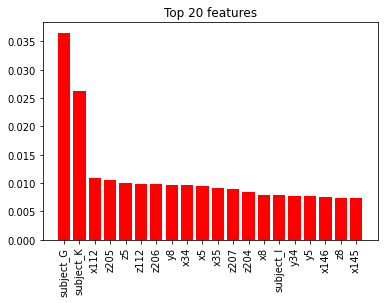

In [ ]:
# Calculate feature importance
model = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Top 20 features")
plt.bar(X_train.columns[indices][:20], importances[indices][:20],
        color="r")
plt.xticks(rotation=90)
plt.show()

As expected, the subject column is the most important feature. Other numerical features provide similar amount of information.

n_features:2  Test AUC:0.697261492832427
n_features:20  Test AUC:0.8274312077772286
n_features:50  Test AUC:0.8229461196243204
n_features:100  Test AUC:0.8204943153732083
n_features:150  Test AUC:0.8432773109243697
n_features:195  Test AUC:0.8770275168891086


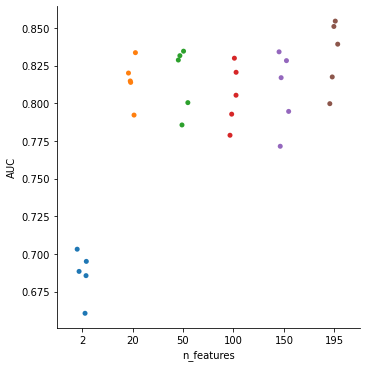

In [ ]:
# Parameter values for testing
values = [2, 20, 50, 100, 150, X_train.shape[1]]

# List to store CV results
result = list()

model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

# Run CV on different parameter values
for value in values:
  top_feat = X_train.columns[indices][:value]
  cv, test_auc = get_auc_score(model, X_train.loc[:, top_feat], y_train, X_test.loc[:, top_feat], y_test)
  result.append(cv)
  print(f'n_features:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['n_features', 'AUC']

# Plot CV result
sns.catplot(x='n_features', y='AUC', data=tmp)

plt.show()

It looks like the top 20 features are already good enough. However, there is a big different in AUC between the full mode and the model with top 20 features. It look like there is some missing information in the lowest 45 features that actually would be important for XGBoost. 

In [ ]:
# Combine the top 20 features and the last 45 features
top_feat = X_train.columns[indices][:20]
last_feat = X_train.columns[indices][-45:]
feat = list(top_feat)+list(last_feat)

cv, test_auc = get_auc_score(model, X_train.loc[:, feat], y_train, X_test.loc[:, feat], y_test)
print(cv)
print(f'n_features:{len(feat)}  Test AUC:{test_auc}')

[0.81771255 0.86626432 0.8791428  0.84631376 0.84069567]
n_features:65  Test AUC:0.8783819410116988


In [ ]:
X_train.columns[np.concatenate((indices[:20], indices[-45:]), axis=0)]

Index(['subject_G', 'subject_K', 'x112', 'z205', 'z5', 'z112', 'z206', 'y8',
       'x34', 'x5', 'x35', 'z207', 'z204', 'x8', 'subject_I', 'y34', 'y5',
       'x146', 'z8', 'x145', 'x71', 'subject_D', 'subject_M', 'phase_3',
       'z106', 'phase_1', 'phase_4', 'subject_C', 'subject_F', 'subject_B',
       'state_B', 'y106', 'state_C', 'state_D', 'x4', 'z4', 'y4', 'x42', 'z43',
       'y114', 'x43', 'y42', 'z42', 'subject_H', 'z114', 'x41', 'y43', 'x114',
       'z44', 'state_A', 'y44', 'y101', 'z115', 'y41', 'z41', 'x44', 'z45',
       'x115', 'y115', 'z116', 'y45', 'y116', 'x45', 'x116', 'state_E'],
      dtype='object')

Indeed the CV and test AUC score is higher than the full model. It suggest that my hypothesis is correct that some features in the lowest rank 45 may be useful for XGBoost.

### Permutate feature importance

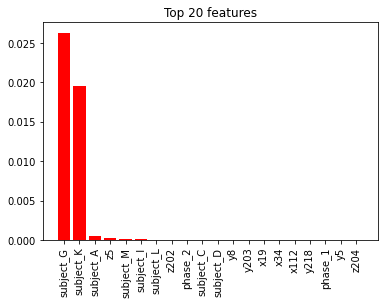

In [ ]:
# Permutation features
model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

model.fit(X_train, y_train)
r = permutation_importance(model, X_train, y_train, scoring='roc_auc', 
                           n_repeats=10, n_jobs=-1, random_state=0)

# Get feature importance index
indices = r.importances_mean.argsort()[::-1]

# Plot permutation-based feature importances 
plt.figure()
plt.title("Top 20 features")
plt.bar(X_train.columns[indices][:20], r.importances_mean[indices][:20],
        color="r")
plt.xticks(rotation=90)
plt.show()

n_features:2  Test AUC:0.697261492832427
n_features:10  Test AUC:0.8465628604382929
n_features:20  Test AUC:0.8840072499588071
n_features:40  Test AUC:0.8785994397759104
n_features:80  Test AUC:0.8752117317515243
n_features:195  Test AUC:0.8758082056351952


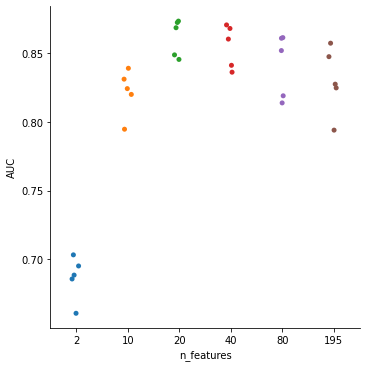

In [ ]:
# Parameter values for testing
values = [2, 10, 20, 40, 80, len(indices)]

# List to store CV results
result = list()

model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

# Run CV on different parameter values
for value in values:
  top_feat = X_train.columns[indices][:value]
  cv, test_auc = get_auc_score(model, X_train.loc[:, top_feat], y_train, X_test.loc[:, top_feat], y_test)
  result.append(cv)
  print(f'n_features:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['n_features', 'AUC']

# Plot CV result
sns.catplot(x='n_features', y='AUC', data=tmp)

plt.show()

It shows that the top 20 features provides the best model performance.

In [ ]:
# Top 20 important features
print(X_train.columns[indices][:20])

Index(['subject_G', 'subject_K', 'subject_A', 'z5', 'subject_M', 'subject_I',
       'subject_L', 'z202', 'phase_2', 'subject_C', 'subject_D', 'y8', 'y203',
       'x19', 'x34', 'x112', 'y218', 'phase_1', 'y5', 'z204'],
      dtype='object')


In [ ]:
model = XGBClassifier(seed=SEED, n_estimators=100, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=20, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

cv, test_auc = get_auc_score(model, X_train.loc[:, index], y_train, X_test.loc[:, index], y_test)
print(cv)
print(f'n_features:{len(index)}  Test AUC:{test_auc}')

[0.84400363 0.87633377 0.84997833 0.88099808 0.87350075]
n_features:20  Test AUC:0.8889581774341065


The CV performance is even better with feature permutation. Using the top 20 features, the test AUC reaches ~0.88. However, the Kaggle public scores seems to be lower. I could use it as a second model for submission.

## Partial dataset without 'Subject' column
In test dataset, 2 classes of subjects, 'J' and 'E' is missing in the train dataset. Since subject is the most significant feature, it makes predictions on those data points very difficult. To solve that, I build another model using the numerical data only. Running the same analysis (change the SUBJECT valuable to False), 2 classifiers (Random Forest and XGBoost) perform the best in cv. Upon checking with Kaggle submission, Random Forest performs better in this case. Since there are over 600 numerical features. Some are correlated with little information, it is important to do feature selection in order to avoid overfitting.  

### Random forest feature importance

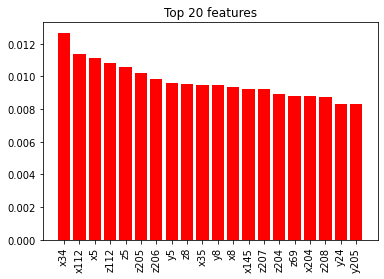

In [ ]:
# Random forest feature importance
# Calculate feature importance
model = RandomForestClassifier(n_estimators=400, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Top 20 features")
plt.bar(X_train.columns[indices][:20], importances[indices][:20],
        color="r")
plt.xticks(rotation=90)
plt.show()

n_features:25  Test AUC:0.7527083759983617
n_features:50  Test AUC:0.7457266707625094
n_features:75  Test AUC:0.7483087582770154
n_features:100  Test AUC:0.7415386715816779
n_features:150  Test AUC:0.7493924499965868
n_features:184  Test AUC:0.7491944842651375


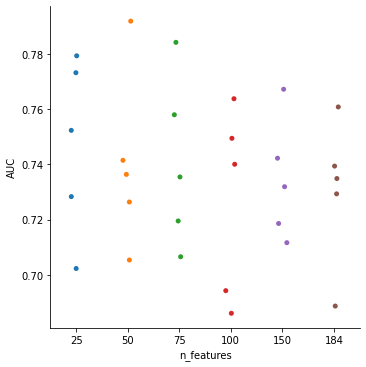

In [ ]:
# Parameter values for testing
values = [25, 50, 75, 100, 150, X_train.shape[1]]

# List to store CV results
result = list()

model = RandomForestClassifier(n_estimators=400, criterion='entropy', max_depth=40, 
                               random_state=SEED, class_weight='balanced')

# Run CV on different parameter values
for value in values:
  top_feat = X_train.columns[indices][:value]
  cv, test_auc = get_auc_score(model, X_train.loc[:, top_feat], y_train, X_test.loc[:, top_feat], y_test)
  result.append(cv)
  print(f'n_features:{value}  Test AUC:{test_auc}')

# Create a dataframe to store CV result 
tmp = pd.DataFrame(result, index=values).T.melt()
tmp.columns = ['n_features', 'AUC']

# Plot CV result
sns.catplot(x='n_features', y='AUC', data=tmp)

plt.show()

Most numerical feature shows similar contribution to the model. To avoid overfitting, first 20 feature seems to be enough. Testing on Kaggle showsthat the performance is not very good. 

### Recursive feature elimination (RFE)

In [ ]:
# Run RFE on Random forest classifier
model = RandomForestClassifier(n_jobs=-1, n_estimators=400, max_depth=40, random_state=SEED, 
                               criterion='entropy', class_weight='balanced')

selector = RFE(model, step=1, verbose=1)
selector = selector.fit(X_train, y_train)

#selector.ranking_

In [ ]:
feature = X_train.columns[selector.support_]
feature

Index(['x5', 'x6', 'x7', 'x8', 'x18', 'x19', 'x33', 'x34', 'x35', 'x58', 'x75',
       'x107', 'x112', 'x143', 'x144', 'x145', 'x146', 'x147', 'x148', 'x173',
       'x177', 'x193', 'x197', 'x201', 'x204', 'x205', 'x206', 'x207', 'x208',
       'x212', 'x213', 'x214', 'x219', 'y5', 'y7', 'y8', 'y17', 'y18', 'y21',
       'y24', 'y26', 'y33', 'y34', 'y35', 'y70', 'y75', 'y108', 'y112', 'y144',
       'y201', 'y202', 'y203', 'y204', 'y205', 'y206', 'y207', 'y208', 'y210',
       'y212', 'y213', 'y218', 'y219', 'y221', 'y222', 'z5', 'z7', 'z8', 'z18',
       'z21', 'z24', 'z33', 'z58', 'z69', 'z75', 'z107', 'z112', 'z143',
       'z144', 'z147', 'z148', 'z161', 'z202', 'z204', 'z205', 'z206', 'z207',
       'z208', 'z210', 'z211', 'z213', 'z220', 'z221'],
      dtype='object')

In [ ]:
# Create feature array for later use
feature = ['x5', 'x6', 'x7', 'x8', 'x18', 'x19', 'x33', 'x34', 'x35', 'x58', 'x75',
       'x107', 'x112', 'x143', 'x144', 'x145', 'x146', 'x147', 'x148', 'x173',
       'x177', 'x193', 'x197', 'x201', 'x204', 'x205', 'x206', 'x207', 'x208',
       'x212', 'x213', 'x214', 'x219', 'y5', 'y7', 'y8', 'y17', 'y18', 'y21',
       'y24', 'y26', 'y33', 'y34', 'y35', 'y70', 'y75', 'y108', 'y112', 'y144',
       'y201', 'y202', 'y203', 'y204', 'y205', 'y206', 'y207', 'y208', 'y210',
       'y212', 'y213', 'y218', 'y219', 'y221', 'y222', 'z5', 'z7', 'z8', 'z18',
       'z21', 'z24', 'z33', 'z58', 'z69', 'z75', 'z107', 'z112', 'z143',
       'z144', 'z147', 'z148', 'z161', 'z202', 'z204', 'z205', 'z206', 'z207',
       'z208', 'z210', 'z211', 'z213', 'z220', 'z221']


In [ ]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=400, max_depth=40, random_state=SEED, 
                               criterion='entropy', class_weight='balanced')

cv, test_auc = get_auc_score(model, X_train.loc[:, feature], y_train, X_test.loc[:, feature], y_test)
print(cv)
print(f'n_features:{len(feature)}  Test AUC:{test_auc}')

[0.70466306 0.73246725 0.71216774 0.77641369 0.74250925]
n_features:92  Test AUC:0.7429227251006894


Using RFE in feature selection, the performance is similar to using RF feature importance. However, the performance is much better in Kaggle submission.

### Boruta


In [ ]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
model = RandomForestClassifier(n_jobs=-1, n_estimators=400, max_depth=40, random_state=SEED, 
                               criterion='entropy', class_weight='balanced')
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=0, max_iter=300)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train.values, y_train.values)


In [ ]:
# Select both confirmed and tentative features
feature2 = list(X_train.columns[feat_selector.support_]) + list(X_train.columns[feat_selector.support_weak_])

In [ ]:
feature2 = ['x34', 'y5', 'z205', 'x35', 'x112', 'x204', 'y8', 'z5', 'z112', 'z207']

In [ ]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=400, max_depth=40, random_state=SEED, 
                               criterion='entropy', class_weight='balanced')

cv, test_auc = get_auc_score(model, X_train.loc[:, feature2], y_train, X_test.loc[:, feature2], y_test)
print(cv)
print(f'Test AUC:{test_auc}')

[0.70391673 0.74250733 0.72636543 0.75683719 0.75987371]
Test AUC:0.7582309372653423


Boruta gives the smallest number of features and the best performance CV and test AUC score. However, the Kaggle score is still less than the one from RFE. It seems that there is still some useful information in the unselected features. 

## Summary III
After trying different submission on Kaggle, it seems that a combination of model perform the best.
1. With subject column -  XGBoost, full features
2. W/o subject column - Random Forest, RFE selected features 

# Clustering using PCA on test data

In [ ]:
# Combine train and test data, one-hot-encoded categorical data
pca_data = test.drop(columns=['subject'])
pca_data = pd.get_dummies(pca_data, columns=['phase','state'])

# Scale data
pca_data = StandardScaler().fit_transform(pca_data)

# Run PCA 
model = PCA(n_components=2)

pca_data = model.fit_transform(pca_data)

# Create dataframe of PC1 & PC2
pca_result = pd.DataFrame(pca_data, columns=['pc1', 'pc2'])

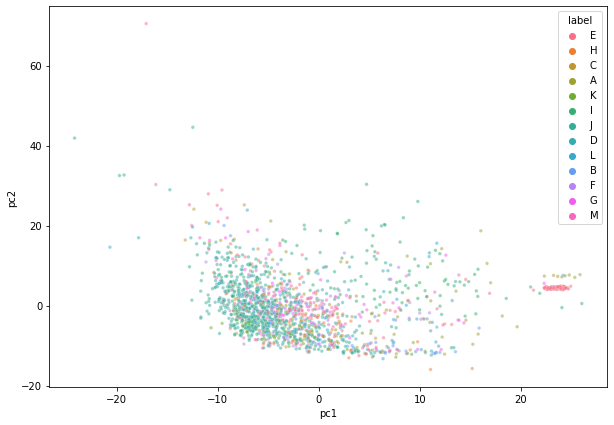

In [ ]:
# Plot test data
pca_result['label'] = test.subject

plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_result, x='pc1', y='pc2', hue='label', s=12, alpha=0.5)

plt.show()

The PCA plot show that there is a very distinct cluster of Subject E in the test data. It is reasonable to assume that they all belong to the same output. Predictions from both XGBoost and Random Forest show that the probability of these data point are around 0.7. Converting them manually to class '1' greatly improve the AUC score.

In [ ]:
# Identifying the distinct cluster E
cluster_E = pca_result.loc[(pca_result.pc1>22) & (pca_result.label=='E'),:]
cluster_E

,pc1,pc2,label
0,23.284935,4.339313,E
4,22.734073,4.071191,E
12,24.189981,4.271160,E
37,23.056577,4.143037,E
44,24.196130,4.280356,E
...,...,...,...
1707,23.006198,4.358518,E
1712,23.831814,4.789957,E
1713,23.666234,4.651477,E
1722,22.970840,4.470401,E


# Submission

In [ ]:
# Full dataset with subject features
X_full = train[list(num_train.columns) + ['subject','phase', 'state']]
X_full = pd.get_dummies(X_full, columns=['subject','phase','state'])

test_full = test[list(num_train.columns) + ['subject','phase', 'state']]
test_full = pd.get_dummies(test_full, columns=['subject','phase','state'])
test_full = test_full.drop(columns=['subject_J','subject_E'])

# Partial dataset without subject features
X_part = train[list(num_train.columns) + ['phase', 'state']]
X_part = pd.get_dummies(X_part, columns=['phase','state'])

test_part = test[list(num_train.columns) + ['phase', 'state']]
test_part = pd.get_dummies(test_part, columns=['phase','state'])

# label of train dataset
Y = train.output

In [ ]:
# Model for dataset with subject column
model = XGBClassifier(seed=SEED, n_estimators=1000, learning_rate=0.02, colsample_bylevel=0.8,
                      max_depth=25, colsample_bytree=0.7, reg_lambda=0.1, 
                      scale_pos_weight = 0.18357862)

# Calculate AUC for test dataset 
model.fit(X_full, Y, eval_metric='auc')
y_pred_full = model.predict_proba(test_full)

In [ ]:
# Model for dataset without subject column
model = RandomForestClassifier(n_estimators=1000, max_depth=40, criterion='entropy', 
                               random_state=SEED, class_weight='balanced')

# Calculate AUC for test dataset 
model.fit(X_part.loc[:,feature], Y)
y_pred_part = model.predict_proba(test_part.loc[:,feature])

In [ ]:
# Combine result of both predictions, use RF model prediction for subject 'J' 
# and 'E'. The rest use XGBoost model
output = list()

for i, s in enumerate(test.subject):
  if s in ['J','E']:
    output.append(y_pred_part[i,1])
  else:
    output.append(y_pred_full[i,1])

submit = pd.DataFrame(range(len(output)), columns=['id'])
submit['output'] = output

submit

,id,output
0,0,0.813000
1,1,0.992618
2,2,0.943340
3,3,0.871345
4,4,0.791000
...,...,...
1727,1727,0.771000
1728,1728,0.885000
1729,1729,0.862000
1730,1730,0.932000


In [ ]:
# Hacking the submission data, assume cluster_E have the same prediction result
submit.output.iloc[cluster_E.index]=1
submit

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id,output
0,0,1.000000
1,1,0.992618
2,2,0.943340
3,3,0.871345
4,4,1.000000
...,...,...
1727,1727,1.000000
1728,1728,0.885000
1729,1729,0.862000
1730,1730,0.932000


In [ ]:
submit.to_csv(path+'submit.csv', index=False)

# Conclusion
In this classification assignment, the strategy starts with EDA on both train the test dataset. Once we find that the train and test datasets are different, my approach is to design 2 different models. 

One model focus on data points where subject is not 'J' or 'E'. Such model is more straight forward since both train and test dataset are similar with very strong categorical feature. The best classifier (i.e. XGBoost) will be suitable in this case.

It is more complicated for data points with subject 'J' and 'E'. Since we don't have much information about them, using the 600 numerical features will certainly overfit. It is especially true when none of the numerical feature is highly significant. RFE feature selection would allow me to find the best features in this case. Random forest classifer will be a better choice since I want a more robust model.

Finally, there is a distinct cluster of data points with subject 'E'. It is reasonable to assume them they belong to the same class. In conclusion, these 3 stepwise approaches are reflected in the finally performance score: 

1. One model: AUC ~0.65
2. Two models: AUC ~0.70
3. Two models + feature selection: AUC ~0.72
4. Two models + feature selection + clustering: AUC ~0.78
 